In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [0, 0]
k = 20

In [5]:
## hyperparameter
w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(1e2)
learning_rate = 2e-5

In [30]:
## Dataset

def get_dataset(Lx, Ly, src, std=0.01, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    r, theta = torch.linspace(0, 1, 200), torch.linspace(0, 2 * np.pi, 240)
    r, theta = torch.meshgrid(r, theta)
    r, theta = r.reshape(-1, 1), theta.reshape(-1, 1)
    x, y = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]
    x_min, x_max = -Lx, Lx
    y_min, y_max = -Ly, Ly
    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    x, y = x[mask].reshape(-1, 1), y[mask].reshape(-1, 1)
    x0, y0 = x[-len(r):, :], y[-len(r):, :]
    f = 1 / (2 * np.pi * std ** 2) * torch.exp(-0.5 * (((x0 - src[0])/std)**2 + ((y0 - src[1])/std)**2))
    a = np.sqrt(2) / 2
    f = torch.cat([a*f, a*f], dim=-1)
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
             f.to(device)

def data_iter(batch_size, x, y, f):
    import random as rd
    num = len(f)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id], f[batch_id]

In [31]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(torch.abs(y) - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), -sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), -sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, src, k, f, L_pml=0.5, sigma0=5):
    x, y = x.reshape(-1, 1).to(device), y.reshape(-1, 1).to(device)
    x, y = x.requires_grad_(), y.requires_grad_()
    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1], x, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2], x, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1], x, torch.ones_like(px[:, 0:1]), create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2], x, torch.ones_like(px[:, 1:2]), create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1], y, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2], y, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1], y, torch.ones_like(py[:, 0:1]), create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2], y, torch.ones_like(py[:, 1:2]), create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p) - f
    del pyy, pxx
    return (res ** 2).mean()

In [32]:
new_train = True
if new_train:
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.apply(sine_init)
    model.net[0].apply(first_layer_sine_init)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    l_lst = []
else:
    import joblib
    state_dict = joblib.load('model_line.joblib')
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    l_lst = []

In [38]:
n_epochs = int(1e2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [39]:
x0, y0, f0 = get_dataset(Lx, Ly, src)
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    for x, y, f in data_iter(10000, x0, y0, f0):
        optimizer.zero_grad()
        loss_pde = loss_fn(model, x, y, src, k, f, L_pml=0.5, sigma0=5)
        loss = loss_pde
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0: 
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    l_lst.append(loss)

/tmp/ipykernel_69838/1934576141.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_69838/1934576141.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
  5%|▌         | 5/100 [00:03<01:16,  1.25it/s]

Epoch 5, Loss: 23802.076171875


 10%|█         | 10/100 [00:07<01:12,  1.25it/s]

Epoch 10, Loss: 4977.43994140625


 15%|█▌        | 15/100 [00:11<01:08,  1.25it/s]

Epoch 15, Loss: 1896.9202880859375


 20%|██        | 20/100 [00:15<01:04,  1.25it/s]

Epoch 20, Loss: 1195.2098388671875


 25%|██▌       | 25/100 [00:19<01:00,  1.25it/s]

Epoch 25, Loss: 886.4262084960938


 30%|███       | 30/100 [00:23<00:56,  1.25it/s]

Epoch 30, Loss: 472.3089599609375


 35%|███▌      | 35/100 [00:27<00:52,  1.25it/s]

Epoch 35, Loss: 295.5702209472656


 40%|████      | 40/100 [00:31<00:48,  1.25it/s]

Epoch 40, Loss: 259.1909484863281


 45%|████▌     | 45/100 [00:35<00:44,  1.24it/s]

Epoch 45, Loss: 193.38815307617188


 50%|█████     | 50/100 [00:39<00:40,  1.24it/s]

Epoch 50, Loss: 167.6007537841797


 55%|█████▌    | 55/100 [00:43<00:36,  1.24it/s]

Epoch 55, Loss: 147.83718872070312


 60%|██████    | 60/100 [00:47<00:32,  1.24it/s]

Epoch 60, Loss: 338.1690979003906


 65%|██████▌   | 65/100 [00:51<00:28,  1.24it/s]

Epoch 65, Loss: 2400.295654296875


 70%|███████   | 70/100 [00:55<00:24,  1.24it/s]

Epoch 70, Loss: 681.4091186523438


 75%|███████▌  | 75/100 [00:59<00:20,  1.24it/s]

Epoch 75, Loss: 213.15206909179688


 80%|████████  | 80/100 [01:03<00:16,  1.24it/s]

Epoch 80, Loss: 123.41399383544922


 85%|████████▌ | 85/100 [01:07<00:12,  1.24it/s]

Epoch 85, Loss: 74.83055114746094


 90%|█████████ | 90/100 [01:11<00:08,  1.24it/s]

Epoch 90, Loss: 57.63239288330078


 95%|█████████▌| 95/100 [01:15<00:04,  1.24it/s]

Epoch 95, Loss: 66.57329559326172


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]

Epoch 100, Loss: 86.55436706542969


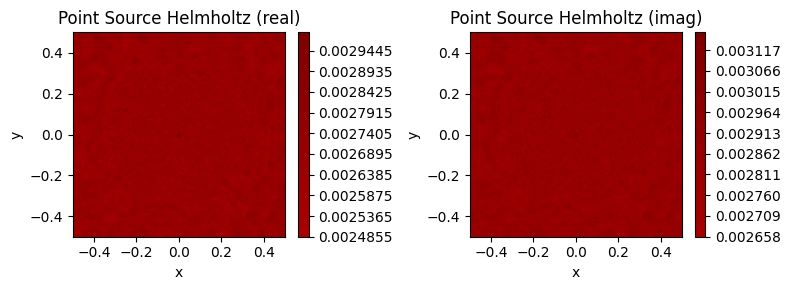

In [37]:
model_pred(model, 0.5, 0.5)

In [ ]:
import joblib
joblib.dump(model.state_dict(), 'model_point.joblib')

In [27]:
loss_min

0.06757024675607681

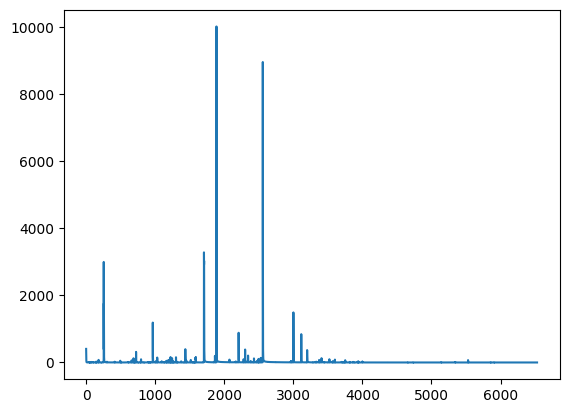

In [59]:
plot_loss(l_lst)

In [37]:
def abs_field(model, Lx, Ly, N=100):
    x, y = torch.linspace(-Lx, Lx, N), torch.linspace(-Ly, Ly, N)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    model = model.to('cpu')
    inputs = torch.cat([x, y], dim=-1)
    p_real = model(inputs)[:, 0].detach().numpy()
    p_imag = model(inputs)[:, 1].detach().numpy()
    p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)
    p = p_real ** 2 + p_imag ** 2

    plt.figure(figsize=(4, 3))
    p_max = np.max(np.abs(p))
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

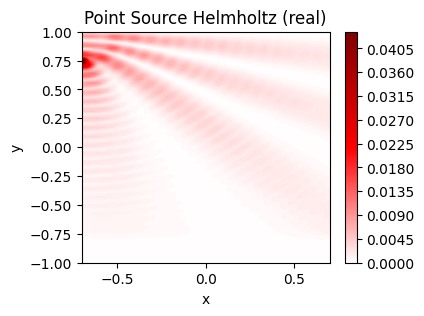

In [38]:
abs_field(model, 0.7, Ly)

Error(Real) -0.15320417284965515, Error(Imag) 0.9929702877998352


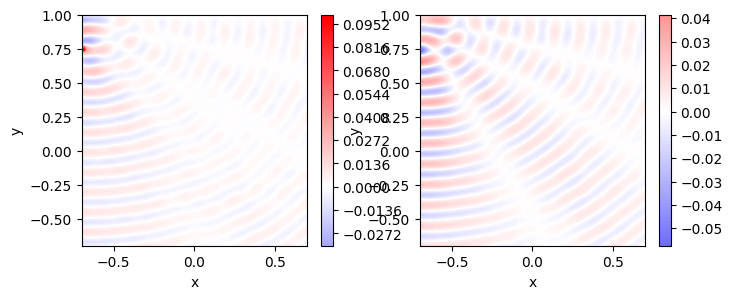

In [42]:
x, y = torch.linspace(-0.7, 0.7, N), torch.linspace(-0.7, 1, N)
x, y = torch.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0].detach().numpy()
p_imag = model(inputs)[:, 1].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

x, y = x.numpy(), y.numpy()
hankel = scipy.special.hankel2(0, k * np.sqrt((x+0.69) ** 2 + (y-0.75) ** 2) + 1e-6) -\
    scipy.special.hankel2(0, k * np.sqrt((x+0.69) ** 2 + (y-1.25) ** 2) + 1e-6)
p_ref = 0.25j * hankel
p_ref_real, p_ref_imag = p_ref.real.reshape(N, N), p_ref.imag.reshape(N, N)

error_real = p_real - p_ref_real
error_imag = p_imag - p_ref_imag

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_real, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
print(f"Error(Real) {error_real.mean() / p_ref_real.mean()}, Error(Imag) {error_imag.mean() / p_ref_imag.mean()}")